# Linear Classifier using SVM

We're going to implement a linear classifier using SVM. The goal here is to show the basic concepts behind Machine Learning. So we won't use any _framework_ such as _Keras_ or _TensorFlow_. We implemented everything by ourselves.

This notebook use the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

In [33]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
import hashlib
from six.moves.urllib.request import urlretrieve

# Config the matplotlib backend as plotting inline in IPython
# %matplotlib inline

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting up the dataset

First we download and extract the dataset

In [2]:
url = 'http://www.cs.toronto.edu/~kriz/' # url from where we get the dataset
data_root = './dataset' # Change me to store data elsewhere

last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()

    last_percent_reported = percent

def md5(fname):
  """Calculate the md5 sum of the file to check its integrity."""
  print ('Calculating md5...')
  hash_md5 = hashlib.md5()
  with open(fname, "rb") as f:
    for chunk in iter(lambda: f.read(4096), b""):
      hash_md5.update(chunk)
  return hash_md5.hexdigest()

def maybe_download(filename, expected_size, expected_md5, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if not os.path.exists('./dataset'):
    os.mkdir('dataset')
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename)
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_size:
    print('Found and verified', dest_filename)
  else:
    raise Exception('Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  if md5(dest_filename) == expected_md5:
    print('No errors during download')
  else:
    raise Exception('The file ' + dest_filename + ' has been corrupted. Try again.')
  return dest_filename

# First download the dataset
dataset = maybe_download('cifar-10-python.tar.gz', 170498071, "c58f30108f718f92721af3b95e74349a")

Attempting to download: cifar-10-python.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./dataset/cifar-10-python.tar.gz
Calculating md5...
No errors during download


In [3]:
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  print('Extraction finished')

# Extract the dataset
maybe_extract(dataset)

Extracting data for ./dataset/cifar-10-python. This may take a while. Please wait.
Extraction finished


## Loading and Preprocessing the data

Here we load the data from the files downloaded and then we preprocess (reduce every image by the mean) in order to get a zero mean dataset.

In [4]:
from data_utils import load_CIFAR10

# Load the raw CIFAR-10 data.
cifar10_dir = 'dataset/cifar-10-batches-py'

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


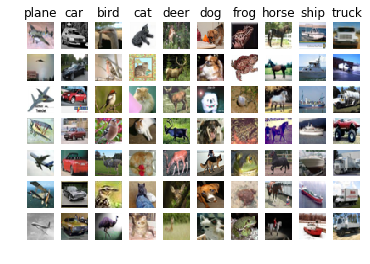

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 7

def visualize_data(dataset, classes, samples_per_class):
    num_classes = len(classes)
    for y, cls in enumerate(classes):
      idxs = np.flatnonzero(y_train == y)
      idxs = np.random.choice(idxs, samples_per_class, replace=False)
      for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((32, 32, 3)).astype('uint8'))
        plt.axis('off')
        if i == 0:
          plt.title(cls)
    plt.show()

visualize_data(X_train, classes, samples_per_class)

In [6]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


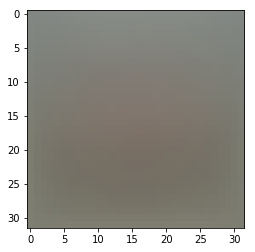

In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

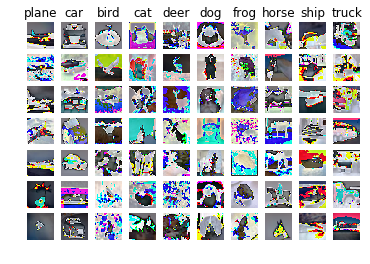

In [9]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# Visualize some samples of each category after preprocessing
visualize_data(X_train, classes, samples_per_class)

In [10]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Now we implement the svm loss and gradient. It's implemented in file **classifiers/linear_svm.py**

In [11]:
# Evaluate the naive implementation of the loss we provided for you:
from classifiers.linear_svm import svm_loss_naive
import time

# Generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.00001 

# For debugging purpose we can calculate the loss with very low W and no regularization
# The result should be near 9 (#number_class - 1)
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.)
print('loss: %f' % (loss, ))

loss: 9.040984


In [12]:
# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 1.284342 analytic: 1.284342, relative error: 3.140766e-11
numerical: 1.946616 analytic: 1.946616, relative error: 9.189894e-11
numerical: 16.382208 analytic: 16.382208, relative error: 1.618034e-11
numerical: 5.047792 analytic: 5.047792, relative error: 5.801445e-11
numerical: -21.108917 analytic: -21.108917, relative error: 4.386253e-12
numerical: 29.656936 analytic: 29.656936, relative error: 5.578313e-12
numerical: -24.952958 analytic: -24.952958, relative error: 7.797246e-13
numerical: 4.661267 analytic: 4.661267, relative error: 1.082236e-10
numerical: -23.604543 analytic: -23.604543, relative error: 2.106918e-11
numerical: -5.443709 analytic: -5.443709, relative error: 2.040937e-11
numerical: 17.327345 analytic: 17.327345, relative error: 7.599523e-12
numerical: 22.142413 analytic: 22.142413, relative error: 3.472905e-13
numerical: -11.080187 analytic: -11.080187, relative error: 3.355222e-12
numerical: 3.468948 analytic: 3.468948, relative error: 1.032355e-10
numerica

In [13]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.040984e+00 computed in 0.190602s
Vectorized loss: 9.040984e+00 computed in 0.041389s
difference: -0.000000


In [14]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.196567s
Vectorized loss and gradient: computed in 0.006055s
difference: 0.000000


In [47]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from classifiers.linear_classifier import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True, X_val=X_val, y_val=y_val)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 792.237324
iteration 100 / 1500: loss 287.216106
iteration 200 / 1500: loss 107.701024
iteration 300 / 1500: loss 42.305264
iteration 400 / 1500: loss 18.718248
iteration 500 / 1500: loss 9.857513
iteration 600 / 1500: loss 7.908467
iteration 700 / 1500: loss 5.865056
iteration 800 / 1500: loss 5.697753
iteration 900 / 1500: loss 5.354665
iteration 1000 / 1500: loss 5.534302
iteration 1100 / 1500: loss 5.704445
iteration 1200 / 1500: loss 5.263492
iteration 1300 / 1500: loss 5.780292
iteration 1400 / 1500: loss 4.905919
That took 38.227528s


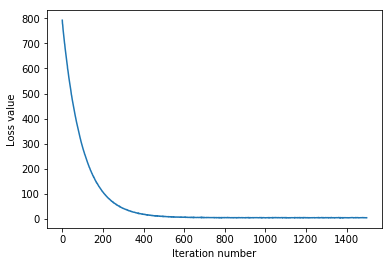

In [48]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [49]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.369102
validation accuracy: 0.384000


In [50]:
# Evaluate the best svm on test set
y_test_pred = svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.356000


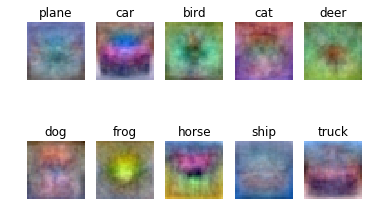

In [51]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])